In [2]:
##this is to test the efficacy of medusa over the internal cobra gapfiller


import cobra
from cobra import Metabolite, Gene, Reaction
import pandas as pd
import medusa
from medusa.test import load_universal_modelseed
import matplotlib.pylab as plt
import pandas as pd


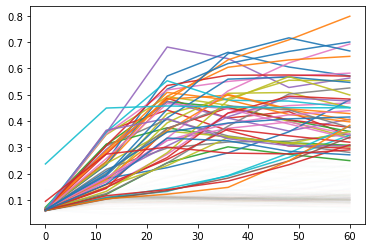

In [252]:
# loop through the sheets of the spreadsheet; each sheet is a biological replicate
# of all 3 of the biolog plates. Columns are time in hours.
reps = {}
for i in range(0,4):
    biolog_raw = pd.read_excel('../data/experiments/biolog_raw.xlsx',sheet_name="rep_"+str(i+1),index_col=0)
    biolog_raw.columns = [col for col in biolog_raw.columns]
    reps[i] = biolog_raw
    
all_biolog = pd.concat([reps[0],reps[1],reps[2],reps[3]])

# convert to mean and std at each time point, 
# and get the max OD at all time points (from means)
mets = reps[0].index.unique()
means = {}
stds = {}
maxODs = {}
for met in mets:
    vals = pd.DataFrame()
    concat_axis = 1
    if met == 'Neg':
        concat_axis = 0
    
    for rep in reps:
        vals = pd.concat([vals,reps[rep].loc[met]],axis=concat_axis)
    
    if met != 'Neg':
        vals = vals.T
    
    means[met] = vals.mean()
    stds[met] = vals.std()
    maxODs[met] = means[met].max()

fig,ax = plt.subplots()
for met in means.keys():
    plotvals = means[met]
    if maxODs[met] > 0.3:
        alpha = 0.9
    else:
        alpha = 0.01
    ax.plot(plotvals.index.values,plotvals.values,alpha=alpha,label = met)
       


In [4]:
# Write the condensed biolog data to a spreadsheet
all_biolog.to_csv("../data/all_biolog.csv")

0.457325

In [253]:
# threshold the growth data to get positive growth conditions only
growth_threshold = 0.3
positive_growth_conditions = {condition:maxODs[condition] for condition in maxODs.keys() if maxODs[condition] > growth_threshold}
# Drop inulin, which is a polymer that cannot be represented in the modelseed namespace
positive_growth_conditions.pop('Inulin')
phenotypes = pd.DataFrame.from_dict(positive_growth_conditions,orient='index')
phenotypes.columns = ["Max OD"]

# Read in the bioog:seed file and merge with the positive growth data to get SEED compound ids for each metabolite
biolog_to_seed = pd.read_csv('../data/biolog_names_to_seed.tsv', sep = '\t')
biolog_to_seed.index = biolog_to_seed["name"]
biolog_to_seed = biolog_to_seed.drop("name", axis=1)
carbon_sources = phenotypes.index.tolist()
phenotypes = phenotypes.merge(biolog_to_seed, left_index=True, right_index=True)
carbon_sources_post_merge = phenotypes.index.tolist()
# Print out the metabolites missing identifiers. These might be expected (e.g. pectin is a polymer that
# cannot be properly represented, so we don't include it)
print("The following compounds are missing; is this expected?", set(carbon_sources) - set(carbon_sources_post_merge))

The following compounds are missing; is this expected? {'Pectin'}


In [254]:
# Load the biolog data from Plata et al., Nature 2014
from medusa.test import load_biolog_plata
biolog_base_composition, biolog_base_dict, biolog_thresholded = load_biolog_plata()

# Remove Heme and H2S2O3 from the biolog base--these compounds are not actually in the base, but are frequently 
# required by modelseed models.
biolog_base_composition = biolog_base_composition.drop(biolog_base_composition.index[biolog_base_composition['ID'] == 'cpd00028_e'])
biolog_base_composition = biolog_base_composition.drop(biolog_base_composition.index[biolog_base_composition['ID'] == 'cpd00268_e'])
if "cpd00028_e" in biolog_base_dict:
    del biolog_base_dict["cpd00028_e"]
if "cpd00268_e" in biolog_base_dict:
    del biolog_base_dict["cpd00268_e"]
biolog_base_composition

,Name,ID
0,H2O,cpd00001_e
1,O2,cpd00007_e
2,Phosphate,cpd00009_e
3,CO2,cpd00011_e
4,NH3,cpd00013_e
5,Mn2+,cpd00030_e
6,Zn2+,cpd00034_e
7,Sulfate,cpd00048_e
8,Cu2+,cpd00058_e
9,Ca2+,cpd00063_e


In [255]:
# load the universal reaction database
from medusa.test import load_universal_modelseed
from cobra.core import Reaction
import cobra

# load the modelseed universal model. This will take a few minutes.
universal = load_universal_modelseed()

# load the psuedomonas syringae draft recon
seed_draft = cobra.io.load_json_model('../data/modelseed_data/modelseed_draft_psy_DC3000.json')

# add all reactions from the draft to the universal if they are not already present
add_to_universal = []
for rxn in seed_draft.reactions:
    if rxn.id != 'bio1':
        if rxn.id not in [r.id for r in universal.reactions]:
            add_to_universal.append(rxn.copy())

universal.add_reactions(add_to_universal)

In [256]:
# Load the model to be gapfilled
model = cobra.io.read_sbml_model("../results/reconstructions/pstv8.xml")


No objective coefficients in model. Unclear what should be optimized


In [257]:
# for now, reformat the improperly-formatted exchange reactions
to_remove = []
for rxn in model.reactions:
    if rxn.id.startswith('EX_'):
        
        # if the reaction has a cytosolic metabolite instead of a extracellular, and is not the biomass
        # exchange reaction, replace it with the extracellular version if it exists in the model.
        # otherwise, remove the reaction
        if rxn.reactants[0].id.endswith('c'):
            print(rxn.bounds)
            if rxn.id is not 'EX_cpd11416_c':
                extracell_version = rxn.reactants[0].id[:-2]+'_e'
                print(extracell_version)
                if extracell_version in [m.id for m in model.metabolites] and 'EX_'+extracell_version not in [r.id for r in model.reactions]:
                    ec_met = model.metabolites.get_by_id(extracell_version)
                    og_met = rxn.reactants[0]
                    rxn.add_metabolites({ec_met:-1})
                    rxn.add_metabolites({og_met:1})
                    # now reformat the ID for the reaction
                    if len(rxn.id.split('_')) == 2:
                        rxn.id = rxn.id+'_e'
                    elif len(rxn.id.split('_')) == 3:
                        rxn.id = rxn.id.split('_')[0] + rxn.id.split('_')[1] + '_e' 
                else:
                    to_remove.append(rxn)
model.remove_reactions(to_remove, remove_orphans=True)
                

(-1000.0, 1000.0)
cpd11416_e
(-1000.0, 1000.0)
cpd03847_e
(-1000.0, 1000.0)
cpd00033_e
(-1000.0, 1000.0)
cpd00383_e
(-1000.0, 1000.0)
cpd00214_e
(-1000.0, 1000.0)
cpd00129_e
(-1000.0, 1000.0)
cpd00069_e
(-1000.0, 1000.0)
cpd00009_e
(-1000.0, 1000.0)
cpd00036_e
(-1000.0, 1000.0)
cpd00132_e
(-1000.0, 1000.0)
cpd00722_e
(-1000.0, 1000.0)
cpd00136_e
(-1000.0, 1000.0)
cpd00137_e
(-1000.0, 1000.0)
cpd00066_e
(-1000.0, 1000.0)
cpd00159_e
(-1000.0, 1000.0)
cpd00053_e
(-1000.0, 1000.0)
cpd01080_e
(-1000.0, 1000.0)
cpd00161_e
(-1000.0, 1000.0)
cpd00314_e
(-1000.0, 1000.0)
cpd00118_e
(-1000.0, 1000.0)
cpd00084_e
(-1000.0, 1000.0)
cpd00107_e
(-1000.0, 1000.0)
cpd00085_e
(-1000.0, 1000.0)
cpd00100_e
(-1000.0, 1000.0)
cpd00035_e
(-1000.0, 1000.0)
cpd00794_e
(-1000.0, 1000.0)
cpd00041_e
(-1000.0, 1000.0)
cpd00073_e
(-1000.0, 1000.0)
cpd00039_e
(-1000.0, 1000.0)
cpd00190_e
(-1000.0, 1000.0)
cpd00179_e
(-1000.0, 1000.0)
cpd00023_e
(-1000.0, 1000.0)
cpd00064_e
(-1000.0, 1000.0)
cpd00105_e
(-1000.0, 1000

In [259]:
# Swap out the biomass function for the one from the draft
model.remove_reactions(['biomass_pto', 
                        'protein' , 
                        'pslpd_c', "pslpdhg_c", 'pslpdfa_c', 
                        'rna' , 
                        'dna', "EX_biomass", 'cor0001_c' , 'cor0002_c',
                       'cor0003_c', 'cor0004_c', 'cor0005_c', 'cor0006_c', 'cor0007_c',
                       'cor0008_c' , 'cor0009_c', 'cor0010_c', 'cor0011_c', 'cor0012_c','EX_cpd16565_e'] , remove_orphans = True)
#model.add_reaction(seed_draft.reactions.get_by_id('bio1').copy())
#model.objective = 'bio1'

In [260]:
add_mets = []
add_exchanges = []
for met in list(biolog_base_dict.keys()):
    try:
        model.metabolites.get_by_id(met)
    except:
        print('no '+met)
        add_met = universal.metabolites.get_by_id(met).copy()
        add_mets.append(add_met)

for met in list(biolog_base_dict.keys()):
    # Search for exchange reactions
    try:
        model.reactions.get_by_id('EX_'+met)
    except:
        add_met = universal.metabolites.get_by_id(met)
        ex_rxn = Reaction('EX_' + met)
        ex_rxn.name = "Exchange reaction for " + met
        ex_rxn.lower_bound = -1000
        ex_rxn.upper_bound = 1000
        ex_rxn.add_metabolites({add_met:-1})
        add_exchanges.append(ex_rxn)
        if add_met.id not in [m.id for m in add_mets]:
            add_mets.append(add_met)

no cpd00099_e


In [261]:
# Find metabolites from the biolog data that are missing in the test model
# and add them from the universal
missing_mets = []
missing_exchanges = []
media_dicts = {}

# remove duplicate conditions by using a set
for met_id in set(phenotypes['seed_id'].tolist()):
    media_dict = biolog_base_dict.copy()
    
    for single_met_id in met_id.split(','):
        # make a boolean indicator for metabolites missing from both
        # the model and the universal model
        missing = False
        
        # add the _e suffix for extracellular metabolites
        single_met_id = single_met_id + '_e'
        
        # search for the metabolite in the model.
        # If missing, try to find it in the universal.
        if single_met_id in [m.id for m in model.metabolites]:
            met = model.metabolites.get_by_id(single_met_id)
        else:
            if single_met_id in [m.id for m in universal.metabolites]:
                met = universal.metabolites.get_by_id(single_met_id)
            else:
                print(single_met_id + ' not in universal. Ignoring metabolite.')
                missing = True
        
        # If the metabolite was in the universal or the model,
        # check for an existing exchange reaction. If not there,
        # create and add the exchange reaction.
        if not missing:
            if 'EX_' + single_met_id not in [rxn.id for rxn in model.reactions]:
                ex_rxn = Reaction('EX_' + single_met_id)
                ex_rxn.name = "Exchange reaction for " + single_met_id
                ex_rxn.lower_bound = -1000
                ex_rxn.upper_bound = 1000
                ex_rxn.add_metabolites({met:-1})
                if ex_rxn.id not in [r.id for r in missing_exchanges]:
                    missing_exchanges.append(ex_rxn)
            if met_id in media_dicts.keys():
                # if media dict was already there, it means this is a double C/N
                # case (E.g. D+L mets). Don't need to alter the rest of the dict.
                media_dict['EX_'+single_met_id] = 1000
            else:
                media_dict = {'EX_'+k:v for k,v in media_dict.items()}
                media_dict['EX_'+single_met_id] = 1000
            
            media_dicts[met_id] = media_dict
            print(met_id + ' was not missing')


cpd00129 was not missing
cpd02143_e not in universal. Ignoring metabolite.
cpd00100 was not missing
cpd00106 was not missing
cpd00108 was not missing
cpd00164 was not missing
cpd00132 was not missing
cpd00054 was not missing
cpd00107 was not missing
cpd02351 was not missing
cpd00035 was not missing
cpd01293 was not missing
cpd00051 was not missing
cpd00249 was not missing
cpd00117 was not missing
cpd00137 was not missing
cpd00036 was not missing
cpd00119 was not missing
cpd00041 was not missing
cpd00477 was not missing
cpd00386 was not missing
cpd00248 was not missing
cpd00121 was not missing
cpd00432 was not missing
cpd11585 was not missing
cpd00105 was not missing
cpd00280 was not missing
cpd00652 was not missing
cpd00027 was not missing
cpd00222 was not missing
cpd24420_e not in universal. Ignoring metabolite.
cpd00154 was not missing
cpd00224 was not missing
cpd00138 was not missing
cpd00076 was not missing
cpd00666 was not missing
cpd00314 was not missing
cpd00609 was not missing


In [262]:
# Add the exchange reactions for metabolites from biolog base
model.add_metabolites(add_mets)
print ("I have added" + str(add_mets))
model.add_reactions(add_exchanges)

# Do the same for single C/N supplements
model.add_metabolites(missing_mets)
model.add_reactions(missing_exchanges)

I have added[<Metabolite cpd00099_e at 0x14f868668>, <Metabolite cpd00007_e at 0x14d28e1d0>, <Metabolite cpd00011_e at 0x14d31f0b8>, <Metabolite cpd00030_e at 0x14cf17c50>, <Metabolite cpd00063_e at 0x14d19f5f8>, <Metabolite cpd00254_e at 0x14d223470>, <Metabolite cpd10515_e at 0x14d306cf8>]


In [263]:
from medusa.reconstruct.expand import iterative_gapfill_from_binary_phenotypes

In [264]:
universal.reactions.rxn05467_c

Reaction identifier,rxn05467_c
Name,CO2 transporter via diffusion
Memory address,0x014eee2a58
Stoichiometry,cpd00011_e <=> cpd00011_c CO2 <=> CO2
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [265]:
#change so that CO2 can only leave the system
# Add CO2 diffusion
rxn = universal.reactions.rxn05467_c.copy()
model.add_reactions([rxn])
# constrain lower bound of CO2 exchange to be 0 or positive
model.reactions.EX_cpd00011_e.lower_bound = 0
# prevent forward flux through the CO2 diffusion reaction (e -> c)
universal.reactions.rxn30753_c.upper_bound = 0
model.reactions.rxn05467_c.upper_bound = 0


Ignoring reaction 'rxn05467_c' since it already exists.


In [45]:
# No longer necessary w/ v8 -- can delete

# import pandas
# df = pandas.read_excel("../data/bio1_biomass.xlsx" , columns = ['id', 'coefficient'])
# for metabolite in model.reactions.bio1.metabolites:
#     model.reactions.bio1.subtract_metabolites({metabolite : model.reactions.bio1.get_coefficient(metabolite.id)})
#     print ("I have subtracted " + metabolite.name + " from the Bio1 equation")
# for row in df.itertuples():
#     try:
#         model.metabolites.get_by_id(row.id)
#         #print ("I found " + row.met)
#     except:
#         if row.id in universal.metabolites:
#             met_to_add = universal.metabolites.get_by_id(row.id)
#             model.add_metabolites([met_to_add])
#         else:
#             print ("I could not find " + row.id +" in universal" )
        
# for row in df.itertuples():
#     model.reactions.bio1.add_metabolites({model.metabolites.get_by_id(row.id) : row.coefficient})
#     print ("I have added " + row.id + " to the Bio1 equation with coefficient " + str(row.coefficient))
    
# print (model.reactions.bio1.metabolites.items())

In [266]:
#set the objective function to the new bio1
model.reactions.bio1.metabolites
#add in reaction for biomass export
ex_rxn = Reaction("EX_cpd11416_c")
ex_rxn.lower_bounds = 0
ex_rxn.upper_bounds = 1000
ex_rxn.add_metabolites({model.metabolites.cpd11416_c:-1})
model.add_reactions([ex_rxn])
#model.objective = "bio1"

In [268]:
model.objective = "bio1"
model.reactions.bio1

Reaction identifier,bio1
Name,GramNegativeBiomass auto biomass
Memory address,0x014e0b3470
Stoichiometry,35.5403092430435 cpd00001_c + 40.00532759 cpd00002_c + 0.00309646685192537 cpd00003_c + 0.00309646685192537 cpd00006_c + 0.00309646685192537 cpd00010_c + 0.00309646685192537 cpd00015_c + 0.00309646... 35.5403092430435 H2O + 40.00532759 ATP + 0.00309646685192537 NAD + 0.00309646685192537 NADP + 0.00309646685192537 CoA + 0.00309646685192537 FAD + 0.00309646685192537 Pyridoxal phosphate + 0.0030964...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [48]:
# Cor pathway should already be in v8 -- skip for now

# #add in the coronatine pathway reaction
# cor1 = Metabolite(
#     'cpd16565_c',
#     formula='C18H24NO4',
#     name='Coronatine',
#     compartment='c')
# cor2 = Metabolite(
#     'cpd16565_e',
#     formula='C18H24NO4',
#     name='Coronatine',
#     compartment='e')
# cpd00211_c = universal.metabolites.cpd00211_c.copy()

# rxn1 = Reaction('cor_synth')
# rxn1.name = 'Coronatine Synthesis'
# rxn1.lower_bound = 0
# rxn1.upper_bound = 1000
# rxn1.gene_reactions_rule = ('PSPTO_0259 or PSPTO_0301 and PSPTO_4709 and PSPTO_4680 or PSPTO_4685 and PSPTO_4681 or PSPTO_4683 and PSPTO_4682 and PSPTO_4690 and PSPTO_4686 and PSPTO_4687')
# rxn1.add_metabolites({model.metabolites.cpd00322_c: -1,
#                      model.metabolites.cpd00029_c : -3,
#                      cpd00211_c : -1,
#                      model.metabolites.cpd00020_c : -1,
#                      model.metabolites.cpd00011_c : 3,
#                      model.metabolites.cpd00067_c : 2,
#                      model.metabolites.cpd00001_c : 3,
#                      cor1 : 1})
# rxn2 = Reaction('cor_trans')
# rxn2.name = 'Coronatine Transport'
# rxn2.lower_bound = 0
# rxn2.upper_bound = 1000
# rxn2.add_metabolites({cor1 : -1,
#                       cor2 : 1})
# rxn3 = Reaction('cor_ex')
# rxn3.name = 'Coronatine Exchange'
# rxn3.lower_bound = 0
# rxn3.upper_bound = 1000
# rxn3.add_metabolites({cor2: -1})

# model.add_reactions ([rxn1, rxn2,rxn3])



In [269]:
# Make O2-producing reactions in the universal non-reversible
O2_rxns = [r.id for r in universal.reactions if 'cpd00007_c' in [m.id for m in r.metabolites]]
for rxn in O2_rxns:
    r_obj = universal.reactions.get_by_id(rxn)
    if 'cpd00007_c' in [r.id for r in r_obj.reactants]:
        r_obj.lower_bound = 0
    elif 'cpd00007_c' in [r.id for r in r_obj.products]:
        r_obj.upper_bound = 0
        
# repeat for reactions in the model
print('Modifying model rxns...\n\n')
O2_rxns = [r.id for r in model.reactions if 'cpd00007_c' in [m.id for m in r.metabolites]]
for rxn in O2_rxns:
    r_obj = model.reactions.get_by_id(rxn)
    # as long as the reaction was not a transport reaction, prevent it form producing cytosolic O2
    all_compartments = [m.compartment for m in r_obj.metabolites]
    if len(set(all_compartments)) < 2:
        if 'cpd00007_c' in [r.id for r in r_obj.reactants]:
            r_obj.lower_bound = 0
        elif 'cpd00007_c' in [r.id for r in r_obj.products]:
            r_obj.upper_bound = 0


# make transport reactions with ATP only operate in the ATP-consuming direction
print('modifying directionality for ATP-producing transport reactions, except F(1) ATPase')
atp_rxns = [r.id for r in model.reactions if 'cpd00002_c' in [m.id for m in r.metabolites]]
for rxn in atp_rxns:
    r_obj = model.reactions.get_by_id(rxn)
    # as long as the reaction was not a transport reaction, prevent it form producing cytosolic O2
    all_compartments = [m.compartment for m in r_obj.metabolites]
    if len(set(all_compartments)) > 1:
        if rxn is not 'rxn10042_c':
            if 'cpd00002_c' in [r.id for r in r_obj.reactants]:
                r_obj.lower_bound = 0
            elif 'cpd00002_c' in [r.id for r in r_obj.products]:
                r_obj.upper_bound = 0

atp_rxns = [r.id for r in universal.reactions if 'cpd00002_c' in [m.id for m in r.metabolites]]
for rxn in atp_rxns:
    r_obj = universal.reactions.get_by_id(rxn)
    # as long as the reaction was not a transport reaction, prevent it form producing cytosolic O2
    all_compartments = [m.compartment for m in r_obj.metabolites]
    if len(set(all_compartments)) > 1:
        if rxn is not 'rxn10042_c':
            if 'cpd00002_c' in [r.id for r in r_obj.reactants]:
                r_obj.lower_bound = 0
            elif 'cpd00002_c' in [r.id for r in r_obj.products]:
                r_obj.upper_bound = 0

# add an exchange reaction to import malonyl coa
malonyl_ex = cobra.Reaction('SK_cpd00070_c')
malonyl_ex.name = 'Malonyl-CoA exchange, cytosolic'
malonyl_ex.id = 'SK_cpd00070_c'
malonyl_ex.add_metabolites = {model.metabolites.get_by_id('cpd00070_c'):-1}
malonyl_ex.bounds = (-10,1000)
model.add_reactions([malonyl_ex])

Modifying model rxns...


modifying directionality for ATP-producing transport reactions, except F(1) ATPase


In [270]:
sol

,fluxes,reduced_costs
rxn00001_c,0.0,1.085937e-15
rxn00002_c,0.0,1.235123e-15
rxn00011_c,0.0,1.412065e-15
rxn00012_c,0.0,-0.000000e+00
rxn00020_c,0.0,5.551115e-17
...,...,...
EX_cpd00028_e,0.0,-3.755457e+00
EX_cpd00393_e,0.0,-1.441047e+00
EX_cpd01188_e,0.0,-4.468703e+00
EX_cpd11606_e,0.0,-6.356135e+00


In [271]:
with model:
    model.add_reactions([r.copy() for r in universal.reactions])
    model.objective = 'bio1'
    for rxn in model.reactions:
        if rxn.id.startswith('EX_'):
            rxn.bounds = (-1000,1000)
    for media in media_dicts.keys():
        model.medium = media_dicts[media]

        #universal.reactions.SK_cpd00070_c.bounds = (-10,1000)
        sol = model.optimize()
        print(sol,media)
        

Ignoring reaction 'rxn00594_c' since it already exists.
Ignoring reaction 'rxn16149_c' since it already exists.
Ignoring reaction 'rxn02201_c' since it already exists.
Ignoring reaction 'rxn00351_c' since it already exists.
Ignoring reaction 'rxn00836_c' since it already exists.
Ignoring reaction 'rxn08180_c' since it already exists.
Ignoring reaction 'rxn00062_c' since it already exists.
Ignoring reaction 'rxn10791_c' since it already exists.
Ignoring reaction 'rxn08709_c' since it already exists.
Ignoring reaction 'rxn00364_c' since it already exists.
Ignoring reaction 'rxn05561_c' since it already exists.
Ignoring reaction 'rxn03408_c' since it already exists.
Ignoring reaction 'rxn02177_c' since it already exists.
Ignoring reaction 'rxn05250_c' since it already exists.
Ignoring reaction 'rxn00646_c' since it already exists.
Ignoring reaction 'rxn05440_c' since it already exists.
Ignoring reaction 'rxn00935_c' since it already exists.
Ignoring reaction 'rxn19118_c' since it already 

<Solution 288.695 at 0x14f9f7518> cpd00129
<Solution 84.226 at 0x14f9f77b8> cpd00100
<Solution 135.708 at 0x14f9f77f0> cpd00106
<Solution 142.057 at 0x14f9f76d8> cpd00108
<Solution 137.752 at 0x14f9f74a8> cpd00164
<Solution 147.986 at 0x14f9f75f8> cpd00132
<Solution 130.021 at 0x14f9f7320> cpd00054
<Solution 338.035 at 0x14f9f76a0> cpd00107
<Solution 180.262 at 0x14f9f75c0> cpd02351
<Solution 157.690 at 0x14f9f77b8> cpd00035
<Solution 225.619 at 0x14f9f7390> cpd01293
<Solution 198.582 at 0x14f9f7780> cpd00051
<Solution 350.215 at 0x14f9f7710> cpd00249
<Solution 157.690 at 0x14f9f7630> cpd00117
<Solution 144.464 at 0x14f9f77f0> cpd00137
<Solution 152.188 at 0x14f9f76d8> cpd00036
<Solution 243.232 at 0x14f9f74a8> cpd00119
<Solution 135.708 at 0x14f9f76a0> cpd00041
<Solution 288.927 at 0x14f9f75c0> cpd00477
<Solution 108.705 at 0x14f9f7780> cpd00386
<Solution 146.817 at 0x14f9f7710> cpd00248
<Solution 142.057 at 0x14f9f72e8> cpd00121
<Solution 65.223 at 0x14f9f7320> cpd00432
<Solution 225

In [272]:
num_cycles = 5
lower_bound = 0.05
flux_cutoff = 1E-15
ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,media_dicts,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=flux_cutoff,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX_')

Constraining lower bound for bio1
starting cycle number 0
starting cycle number 1
starting cycle number 2
starting cycle number 3
starting cycle number 4
building features...
updating members...


In [273]:
ensemble.members

[<Member PST_gapfilled_0 at 0x14038f518>,
 <Member PST_gapfilled_1 at 0x13f119f28>,
 <Member PST_gapfilled_2 at 0x1292f3eb8>,
 <Member PST_gapfilled_3 at 0x1292f32e8>,
 <Member PST_gapfilled_4 at 0x1292f35c0>]

In [274]:
from medusa.flux_analysis import flux_balance
fluxes = flux_balance.optimize_ensemble(ensemble,return_flux='bio1')
fluxes

,bio1
PST_gapfilled_0,526.342715
PST_gapfilled_1,547.738760
PST_gapfilled_2,526.403165
PST_gapfilled_3,526.342715
PST_gapfilled_4,526.342715


In [275]:
ensemble.set_state(ensemble.members[0])
gf_mod1 = ensemble.base_model.copy()


In [276]:
active_exchanges = gf_mod1.optimize().fluxes[[r.id for r in gf_mod1.boundary]][abs(gf_mod1.optimize().fluxes[[r.id for r in gf_mod1.boundary]]) > 1E-10]
active_exchanges = pd.DataFrame(active_exchanges)
active_exchanges['met_name'] = [gf_mod1.metabolites.get_by_id(ind[3:]).name for ind in active_exchanges.index]
active_exchanges.sort_values(by='fluxes')

,fluxes,met_name
EX_cpd01293_e,-1000.000000,5-Oxoproline
EX_cpd00121_e,-1000.000000,L-Inositol
EX_cpd00129_e,-1000.000000,L-Proline
EX_cpd00007_e,-1000.000000,O2
EX_cpd00246_e,-1000.000000,Inosine
EX_cpd00076_e,-977.785208,Sucrose
EX_cpd00130_e,-826.789523,L-Malate
EX_cpd00080_e,-765.076381,Glycerol-3-phosphate
EX_cpd00164_e,-475.017156,Glucuronate
EX_cpd00132_e,-453.783506,L-Asparagine


In [277]:
gf_mod1.medium = media_dicts['cpd00129']
for rxn in gf_mod1.boundary:
    if rxn.id not in media_dicts['cpd00129'].keys():
        rxn.lower_bound = 0
gf_mod1.reactions.EX_cpd00129_e.lower_bound = -1
print(gf_mod1.optimize())
pfba_solution = cobra.flux_analysis.pfba(gf_mod1)

<Solution 0.284 at 0x13e3d4518>


In [149]:
gf_mod1.reactions.rxn05164_c

Reaction identifier,rxn05164_c
Name,ATP phosphohydrolase (polar-amino-acid-importing)
Memory address,0x0138e74c18
Stoichiometry,cpd00001_c + cpd00002_c + cpd00119_e --> cpd00008_c + cpd00009_c + cpd00067_c + cpd00119_c H2O + ATP + L-Histidine --> ADP + Phosphate + H+ + L-Histidine
GPR,PSPTO_5358 and PSPTO_5359 and PSPTO_5360 and PSPTO_5357
Lower bound,0.0
Upper bound,1000.0


In [278]:
active_exchanges = pfba_solution.fluxes[[r.id for r in gf_mod1.boundary]][abs(pfba_solution.fluxes[[r.id for r in gf_mod1.boundary]]) > 1E-10]
active_exchanges = pd.DataFrame(active_exchanges)
active_exchanges['met_name'] = [gf_mod1.metabolites.get_by_id(ind[3:]).name for ind in active_exchanges.index]
active_exchanges.sort_values(by='fluxes')

,fluxes,met_name
EX_cpd00129_e,-1.000000,L-Proline
EX_cpd00067_e,-0.697628,H+
EX_cpd00048_e,-0.007479,Sulfate
EX_cpd00007_e,-0.007074,O2
EX_cpd10515_e,-0.003518,Fe2+
EX_cpd00099_e,-0.000880,Cl-
EX_cpd00030_e,-0.000880,Mn2+
EX_cpd00034_e,-0.000880,Zn2+
EX_cpd00254_e,-0.000880,Mg
EX_cpd00063_e,-0.000880,Ca2+


In [279]:
active_rxns = pfba_solution.fluxes[[r.id for r in gf_mod1.reactions]][abs(pfba_solution.fluxes[[r.id for r in gf_mod1.reactions]]) > 1E-10]
active_rxns

rxn00011_c    0.038024
rxn00029_c    0.007036
rxn00048_c    0.001759
rxn00056_c    0.000220
rxn00060_c    0.001759
                ...   
rxn11384_c   -0.024197
rxn10473_c   -0.000880
rxn05443_c    0.024197
rxn34028_c    0.007552
rxn05375_c    0.024197
Name: fluxes, Length: 436, dtype: float64

In [115]:
#help functions for printing reaction info in console
def print_rxns_from_met(met,model):
    for rxn in met.reactions:
        rxn_obj = model.reactions.get_by_id(rxn.id)
        print(rxn_obj.name)
        print(rxn_obj)
        print(rxn_obj.build_reaction_string(use_metabolite_names=True))
        print()
        
def print_rxn_info_from_list(rxns,model):
    for rxn in rxns:
        rxn_obj = model.reactions.get_by_id(rxn)
        print(rxn_obj.name)
        print(rxn_obj)
        print(rxn_obj.build_reaction_string(use_metabolite_names=True))
        print()

In [177]:
print_rxns_from_met(universal.metabolites.cpd15709_c,universal)

stearoyl-UDP-glucosyltransferase (triglucosyl)
rxn10246_c: cpd00026_c + cpd15730_c <=> cpd00014_c + cpd15709_c
UDP-glucose + Diglucosyl-1,2 distearoylglycerol <=> UDP + Triglucosyl-1,2 distearoylglycerol



In [184]:
# get all the reactions containing O2 in the reconstruction
CO2_rxns = [r.id for r in gf_mod1.reactions if 'cpd00002_c' in [m.id for m in r.metabolites]]
print(active_rxns.loc[[r for r in CO2_rxns if r in active_rxns.index]].sort_values())
print_rxn_info_from_list(active_rxns.loc[[r for r in CO2_rxns if r in active_rxns.index]].index,gf_mod1)

rxn05513_c   -11.805414
rxn10447_c   -11.802423
rxn09502_c    -0.164170
rxn30478_c    -0.143992
rxn01114_c    -0.098502
                ...    
rxn00364_c     0.534476
rxn00409_c     0.534476
bio1           0.965705
rxn01100_c     1.706982
rxn10042_c    21.023782
Name: fluxes, Length: 67, dtype: float64
ATP:NAD+ 2'-phosphotransferase
rxn00077_c: cpd00002_c + cpd00003_c <=> cpd00006_c + cpd00008_c + cpd00067_c
ATP + NAD <=> NADP + ADP + H+

ATP:AMP phosphotransferase
rxn00097_c: cpd00002_c + cpd00018_c + cpd00067_c <=> 2.0 cpd00008_c
ATP + AMP + H+ <=> 2.0 ADP

ATP:dephospho-CoA 3'-phosphotransferase
rxn00100_c: cpd00002_c + cpd00655_c --> cpd00008_c + cpd00010_c + cpd00067_c
ATP + Dephospho-CoA --> ADP + CoA + H+

Carbon-dioxide:ammonia ligase (ADP-forming,carbamate-phosphorylating)
rxn00113_c: cpd00001_c + 2.0 cpd00002_c + cpd00011_c + cpd00013_c <=> 2.0 cpd00008_c + cpd00009_c + 3.0 cpd00067_c + cpd00146_c
H2O + 2.0 ATP + CO2 + NH3 <=> 2.0 ADP + Phosphate + 3.0 H+ + Carbamoylphosphat

In [182]:
model.reactions.rxn00258_c

Reaction identifier,rxn00258_c
Name,Malonyl-CoA:pyruvate carboxytransferase
Memory address,0x013a4d0f60
Stoichiometry,cpd00020_c + cpd00070_c <=> cpd00022_c + cpd00032_c Pyruvate + Malonyl-CoA <=> Acetyl-CoA + Oxaloacetate
GPR,PSPTO_2922 or PSPTO_4860
Lower bound,-1000.0
Upper bound,1000.0


In [96]:
universal.reactions.TRANS-RXN-194

Reaction identifier,rxn34028_c
Name,Lumped Orotate Synthesis
Memory address,0x012b257b70
Stoichiometry,0.5 cpd00007_c + cpd00067_c + cpd00343_c --> 2.0 cpd00001_c + cpd00247_c 0.5 O2 + H+ + N-Carbamoyl-L-aspartate --> 2.0 H2O + Orotate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [97]:
# load previous model version to see where cytosolic exchange reactions came from
# Load the model to be gapfilled
modelv6 = cobra.io.read_sbml_model("../results/reconstructions/PST_pao1_temp_biomass_v4.sbml")

[rxn.metabolites for rxn in modelv6.reactions if rxn.id.startswith('EX_')]

[{<Metabolite cpd00797_e at 0x132f5d5c0>: -1.0},
 {<Metabolite cpd17085_e at 0x132f5d470>: -1.0},
 {<Metabolite cpd00176_e at 0x132f5d550>: -1.0},
 {<Metabolite cpd00024_e at 0x132f5d320>: -1.0},
 {<Metabolite cpd00489_e at 0x132f5d080>: -1.0},
 {<Metabolite cpd00147_c at 0x132f5d358>: -1.0},
 {<Metabolite cpd00029_e at 0x132f5d2b0>: -1.0},
 {<Metabolite cpd00142_e at 0x132f5d390>: -1.0},
 {<Metabolite cpd00182_e at 0x132f5d240>: -1.0},
 {<Metabolite cpd11587_e at 0x132f5d0f0>: -1.0},
 {<Metabolite cpd11584_e at 0x132f5d278>: -1.0},
 {<Metabolite cpd11593_e at 0x132f5d048>: -1.0},
 {<Metabolite cpd11583_e at 0x132f5beb8>: -1.0},
 {<Metabolite cpd11586_e at 0x132f5b940>: -1.0},
 {<Metabolite cpd11582_e at 0x132f5bf60>: -1.0},
 {<Metabolite cpd01092_e at 0x132f5bd30>: -1.0},
 {<Metabolite cpd00162_e at 0x132f5bdd8>: -1.0},
 {<Metabolite cpd01262_e at 0x132f5bb38>: -1.0},
 {<Metabolite cpd01048_e at 0x132f5bcf8>: -1.0},
 {<Metabolite cpd04098_e at 0x132f5bda0>: -1.0},
 {<Metabolite cpd005

In [96]:
modelv6.reactions.EX_cpd00147_LPAREN_c_RPAREN_

Reaction identifier,EX_cpd00147_LPAREN_c_RPAREN_
Name,EX 5-Methylthioadenosine c
Memory address,0x013a330ac8
Stoichiometry,cpd00147_c --> 5-Methylthioadenosine -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [22]:
save_dir = ("../results/ensembles/pto_ensemble_100_round2.pickle")
ensemble.to_pickle(save_dir)

In [200]:
media_dicts

{'cpd00246': {'EX_cpd00001_e': 1000,
  'EX_cpd00007_e': 1000,
  'EX_cpd00009_e': 1000,
  'EX_cpd00011_e': 1000,
  'EX_cpd00013_e': 1000,
  'EX_cpd00030_e': 1000,
  'EX_cpd00034_e': 1000,
  'EX_cpd00048_e': 1000,
  'EX_cpd00058_e': 1000,
  'EX_cpd00063_e': 1000,
  'EX_cpd00067_e': 1000,
  'EX_cpd00099_e': 1000,
  'EX_cpd00149_e': 1000,
  'EX_cpd00205_e': 1000,
  'EX_cpd00254_e': 1000,
  'EX_cpd00971_e': 1000,
  'EX_cpd10515_e': 1000,
  'EX_cpd10516_e': 1000,
  'EX_cpd00268_e': 1000,
  'EX_cpd00246_e': 1000},
 'cpd00249': {'EX_cpd00001_e': 1000,
  'EX_cpd00007_e': 1000,
  'EX_cpd00009_e': 1000,
  'EX_cpd00011_e': 1000,
  'EX_cpd00013_e': 1000,
  'EX_cpd00030_e': 1000,
  'EX_cpd00034_e': 1000,
  'EX_cpd00048_e': 1000,
  'EX_cpd00058_e': 1000,
  'EX_cpd00063_e': 1000,
  'EX_cpd00067_e': 1000,
  'EX_cpd00099_e': 1000,
  'EX_cpd00149_e': 1000,
  'EX_cpd00205_e': 1000,
  'EX_cpd00254_e': 1000,
  'EX_cpd00971_e': 1000,
  'EX_cpd10515_e': 1000,
  'EX_cpd10516_e': 1000,
  'EX_cpd00268_e': 1000,


In [150]:
for rxn in universal.reactions:
    if "EX_" in rxn.id:
        universal.remove_reactions([rxn], remove_orphans = True)
    else:
        pass

In [151]:
for rxn in universal.reactions:
    if "EX_" in rxn.id:
        print(rxn.id)

In [33]:
#run some fba simulations on the ensebmles
biolog_base_dict
#biolog_base_composition = {'EX_'+component:1000 for component in biolog_base_composition['ID']}
#biolog_base_composition['EX_cpd00027_e'] = 0
#biolog_base_composition['EX_cpd00082_e'] = 0
#biolog_base_composition['EX_cpd00028_e'] = 0
#biolog_base_composition['EX_cpd00011_e'] = 0



{'cpd00001_e': 1000,
 'cpd00007_e': 1000,
 'cpd00009_e': 1000,
 'cpd00011_e': 1000,
 'cpd00013_e': 1000,
 'cpd00030_e': 1000,
 'cpd00034_e': 1000,
 'cpd00048_e': 1000,
 'cpd00058_e': 1000,
 'cpd00063_e': 1000,
 'cpd00067_e': 1000,
 'cpd00099_e': 1000,
 'cpd00149_e': 1000,
 'cpd00205_e': 1000,
 'cpd00254_e': 1000,
 'cpd00971_e': 1000,
 'cpd10515_e': 1000,
 'cpd10516_e': 1000,
 'cpd00268_e': 1000}

In [72]:
water = {'EX_cpd00001_e' : 1000,'EX_cpd00007_e' : 1000, 'EX_cpd00009_e' : 1000, 'EX_cpd00011_e' : 1 , 
         'EX_cpd00013_e' : 1000, 'EX_cpd00030_e' : 1000, 'EX_cpd00034_e' : 1000, 'EX_cpd00048_e' : 1000, 
         'EX_cpd00058_e' : 1000, 'EX_cpd00063_e' : 1000, 'EX_cpd00067_e' : 1000, 'EX_cpd00099_e' : 1000, 
         'EX_cpd00268_e' : 1000, 'EX_cpd10515_e' : 1000, 'EX_cpd10516_e' : 1000, 'EX_cpd00971_e' : 1000, 
         'EX_cpd00254_e' : 1000, 'EX_cpd00205_e' : 1000,'EX_cpd00149_e' : 1000, 'EX_cpd00137_e' : 0}

In [326]:
ensemble.base_model.medium = water

In [327]:
from medusa.flux_analysis import flux_balance
fluxes = flux_balance.optimize_ensemble(ensemble,return_flux='bio1')

In [328]:
fluxes.head(100)

,bio1
PST_gapfilled_0,0.026235
PST_gapfilled_1,0.026235
PST_gapfilled_2,0.026235
PST_gapfilled_3,0.026235
PST_gapfilled_4,0.026235
PST_gapfilled_5,0.026235
PST_gapfilled_6,0.026235
PST_gapfilled_7,0.026235
PST_gapfilled_8,0.026235
PST_gapfilled_9,0.026235


In [190]:
#close all lower bounds of reactions that could consume CO2
model.reactions.rxn00113_c.lower_bound = -1000
model.reactions.rxn00113_c.upper_bound = 0
model.reactions.rxn00501_c.lower_bound = 0
model.reactions.rxn00671_c.lower_bound = 0
model.reactions.rxn00866_c.lower_bound = 0
model.reactions.rxn00908_c.lower_bound = 0
model.reactions.rxn01802_c.lower_bound = 0
model.reactions.rxn02288_c.lower_bound = 0
model.reactions.rxn02303_c.lower_bound = 0
model.reactions.rxn03384_c.lower_bound = 0
model.reactions.rxn04704_c.lower_bound = 0
model.reactions.rxn08094_c.lower_bound = 0
model.reactions.rxn09197_c.lower_bound = 0
model.reactions.rxn09198_c.lower_bound = 0
model.reactions.rxn09199_c.lower_bound = 0
model.reactions.rxn09200_c.lower_bound = 0
model.reactions.rxn09201_c.lower_bound = 0
model.reactions.rxn09202_c.lower_bound = 0
model.reactions.rxn09203_c.lower_bound = 0
model.reactions.rxn05064_c.lower_bound = 0
model.reactions.rxn10232_c.lower_bound = 0
model.reactions.rxn10233_c.lower_bound = 0
model.reactions.rxn10234_c.lower_bound = 0
model.reactions.rxn10235_c.lower_bound = 0
model.reactions.rxn10236_c.lower_bound = 0
model.reactions.rxn10237_c.lower_bound = 0
model.reactions.rxn02277_c.lower_bound = -1000
model.reactions.rxn02277_c.upper_bound = 0

In [3]:
from pickle import load
with open("../results/ensembles/pto_ensemble_100_cfixed.pickle", 'rb') as infile:
    ensemble = load(infile)

In [4]:
#modify the gprs to include the manually annotated gene:reactions pairs from KEGG and BLASTing
missing_gprs_df = pd.read_excel('../data/gpr_kegg_missing_reactions.xlsx', columns = ['rxn_id', 'gpr'])
rxn_gpr_dict = {}
for idx, row in missing_gprs_df.iterrows():
    rxn_gpr_dict[row.rxn_id + '_c'] = row.gpr

In [418]:
_c_dict = {}
for rxn,gpr in 

SyntaxError: invalid syntax (<ipython-input-418-c1e8f2eff9a3>, line 2)

In [5]:

for rxn,gpr in rxn_gpr_dict.items():
    if rxn in str(ensemble.base_model.reactions):
        ensemble.base_model.reactions.get_by_id(rxn).gene_reaction_rule = gpr

In [395]:
save_dir = ("../results/ensembles/pto_ensemble_100_genes_added_1.pickle")
ensemble.to_pickle(save_dir)

In [7]:
new_genes_no_rxn = {}
for rxn in ensemble.base_model.reactions:
    new_genes_no_rxn[rxn.id] = rxn.gene_reaction_rule

In [11]:
import csv
with open('../data/reactions_from_ensemble.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in new_genes_no_rxn.items():
        writer.writerow([key, value])

In [413]:
ensemble.base_model.genes.PSPTOO_4569

Gene identifier,PSPTOO_4569
Name,
Memory address,0x014e8029b0
Functional,True
In 1 reaction(s),rxn00623_c
